In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lendingclub import config

pd.set_option('max_columns', 999)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

ppath = config.prj_dir
dpath = config.data_dir

In [2]:
all_scores = pd.read_feather(os.path.join(config.data_dir, 'eval_loan_info_scored.fth'))
base_loan_info = pd.read_feather(os.path.join(config.data_dir, 'base_loan_info.fth'))
with open(os.path.join(config.data_dir, 'train_test_ids.pkl'), 'rb') as f:
    train_test_ids = pickle.load(f)
print(all_scores.shape, base_loan_info.shape)

(2507335, 46) (2507335, 90)


# USE TEST IDS TO GENERATE DISTRIBUTIONS OF END_M

In [19]:
# examine the distribution of high maturity time loans for which months they default and prepay
test_id = train_test_ids['test'] # <- test ids
done_loans = all_scores.query('id in @test_id and maturity_time >= .95')
done_loans['months_recorded'] = ((done_loans['end_d'] - done_loans['issue_d'])/np.timedelta64(1, 'M')).round()
def_statuses = ['charged_off', 'defaulted']
def_loans = done_loans.query('loan_status in @def_statuses')
paid_loans = done_loans.query('loan_status not in @def_statuses')

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


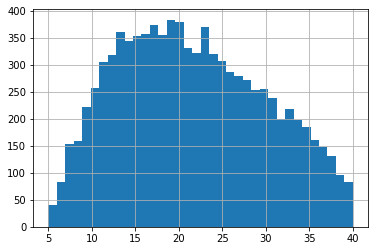

In [20]:
# check how long loans pay for if defaulting or paying for 36 term loans
query = 'term == 36 and months_recorded <= 40 and maturity_time >= .95'
def_probs = (def_loans.query(query)['months_recorded'].value_counts(dropna=False)/len(def_loans.query(query))).to_dict()
def_m, def_prob = zip(*def_probs.items())
def_loans.query(query)['months_recorded'].hist(bins=36)

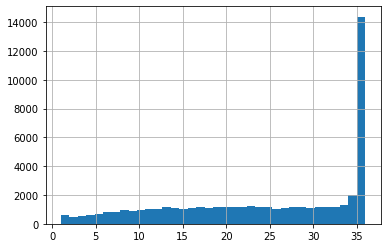

In [21]:
query = 'term == 36 and months_recorded <= 36 and months_recorded >= 1 and maturity_time >= .95'
paid_probs = (paid_loans.query(query)['months_recorded'].value_counts(dropna=False)/len(paid_loans.query(query))).to_dict()
paid_m, paid_prob = zip(*paid_probs.items())
paid_loans.query(query)['months_recorded'].hist(bins=36)

In [27]:
print(def_m)

(19.0, 20.0, 17.0, 23.0, 13.0, 16.0, 18.0, 15.0, 14.0, 21.0, 22.0, 24.0, 12.0, 25.0, 11.0, 26.0, 27.0, 28.0, 10.0, 30.0, 29.0, 31.0, 9.0, 33.0, 32.0, 34.0, 35.0, 36.0, 8.0, 7.0, 37.0, 38.0, 39.0, 6.0, 40.0, 5.0)


In [28]:
print(def_prob)

(0.04215276249174554, 0.04171252476337222, 0.04105216817081224, 0.040721989874532245, 0.03962139555359894, 0.039181157825225625, 0.03896103896103896, 0.0387409200968523, 0.037860444640105656, 0.036429672022892365, 0.03543913713405239, 0.035108958837772396, 0.03499889940567907, 0.033678186220559105, 0.03345806735637244, 0.031587057010785825, 0.030706581554039183, 0.029826106097292537, 0.028285274047985913, 0.02806515518379925, 0.02784503631961259, 0.026194144838212634, 0.02443319392471935, 0.023992956196346026, 0.02201188641866608, 0.02168170812238609, 0.020360994937266123, 0.017609509134932862, 0.017499449702839533, 0.01694915254237288, 0.016178736517719568, 0.014417785604226283, 0.010455646048866387, 0.009134932863746423, 0.009134932863746423, 0.004512436715826546)


In [29]:
print(paid_m)

(36.0, 35.0, 34.0, 23.0, 33.0, 29.0, 32.0, 20.0, 19.0, 22.0, 24.0, 25.0, 21.0, 17.0, 28.0, 31.0, 13.0, 14.0, 18.0, 30.0, 27.0, 16.0, 15.0, 26.0, 12.0, 11.0, 8.0, 10.0, 9.0, 7.0, 6.0, 5.0, 1.0, 4.0, 3.0, 2.0)


In [30]:
print(paid_prob)

(0.2824742268041237, 0.039646539027982326, 0.025508100147275406, 0.02411389297987236, 0.023524791359842905, 0.02346588119783996, 0.02323024054982818, 0.022876779577810504, 0.022778595974472262, 0.022739322533136964, 0.02268041237113402, 0.022523318605792833, 0.022484045164457536, 0.02242513500245459, 0.02242513500245459, 0.02232695139911635, 0.02228767795778105, 0.021678939617083948, 0.021521845851742757, 0.02150220913107511, 0.02124693176239568, 0.02124693176239568, 0.02059891998036328, 0.020500736377025038, 0.02020618556701031, 0.019695630829651447, 0.01885125184094256, 0.018654884634266077, 0.018046146293568974, 0.01616102110947472, 0.015434462444771722, 0.013294059891998037, 0.012135493372606774, 0.01180166912125675, 0.00997545409916544, 0.009936180657830142)


In [22]:
# Let's model some portfolios

In [31]:
%%writefile ../../lendingclub/modeling/portfolio_simulating.py
import numpy as np

def make_loan_array(l_type, funded, pmt, rate, term, month, n_months, cfs, theoretic = False, end_m = None):
    '''
    3 l_types:
    A) default immediately, take 5 months
    B) Fully Prepay between 6-12 months. 
    C) Fully Prepay/pay between 24-36 months
    month: what month the loan was invested in (starts at 0)
    '''
    if theoretic:
        add_m = np.random.choice(np.arange(-3,4))
        if l_type == 'A':
            add_cfs = np.zeros(1)
        else:
            if l_type == 'B':
                n_m = 9+add_m+1
                print(n_m)
            elif l_type == 'C':
                n_m = 33+add_m+1
            per = np.arange(n_m) + 1
            add_cfs = np.tile(pmt, (n_m+1))
            rem_princp = (1 - np.ppmt(rate, per, term, funded, 0).sum()).round(2)
            add_cfs[-1] += rem_princp
        add_cfs[0] = funded
        cfs[month:month+len(add_cfs)] += add_cfs
        return cfs
    else:
        # Only 2 l_types 'A' default and 'B' (pre)paid, use end_m
        if l_type == 'A':
            n_m = end_m
            add_cfs = np.tile(pmt, int(n_m - (4)))
        if l_type == 'B':
            n_m = end_m
            per = np.arange(n_m) + 1
            add_cfs = np.tile(pmt, (int(n_m+1)))
            rem_princp = (1 - np.ppmt(rate, per, term, funded, 0).sum()).round(2)
            add_cfs[-1] += rem_princp
        add_cfs[0] = funded
        cfs[month:month+len(add_cfs)] += add_cfs
        return cfs

def sim_portfolio(n_months=120, starting_loans=2000, cfs=None, funded=-1,
                  rate = .07/12, term = 36, theoretic = False, def_vs_pay_prob=[.15, .85]):
    '''
    Simulate a portfolio for INVESTING for n_months. Actual portfolio winddown
    may take up to 36 months longer
    funded is the loan amount that will be used (e.g. -1 is one dollar funded to loan)
    '''
    #2019-11-23 18:19:03 added these probability of def/pay loan ending in which month
    def_m = (19.0, 20.0, 17.0, 23.0, 13.0, 16.0, 18.0, 15.0, 14.0, 21.0, 22.0, 24.0, 12.0, 25.0, 11.0, 26.0, 27.0, 28.0, 10.0, 30.0, 29.0, 31.0, 9.0, 33.0, 32.0, 34.0, 35.0, 36.0, 8.0, 7.0, 37.0, 38.0, 39.0, 6.0, 40.0, 5.0)
    def_prob = (0.04215276249174554, 0.04171252476337222, 0.04105216817081224, 0.040721989874532245, 0.03962139555359894, 0.039181157825225625, 0.03896103896103896, 0.0387409200968523, 0.037860444640105656, 0.036429672022892365, 0.03543913713405239, 0.035108958837772396, 0.03499889940567907, 0.033678186220559105, 0.03345806735637244, 0.031587057010785825, 0.030706581554039183, 0.029826106097292537, 0.028285274047985913, 0.02806515518379925, 0.02784503631961259, 0.026194144838212634, 0.02443319392471935, 0.023992956196346026, 0.02201188641866608, 0.02168170812238609, 0.020360994937266123, 0.017609509134932862, 0.017499449702839533, 0.01694915254237288, 0.016178736517719568, 0.014417785604226283, 0.010455646048866387, 0.009134932863746423, 0.009134932863746423, 0.004512436715826546)
    paid_m = (36.0, 35.0, 34.0, 23.0, 33.0, 29.0, 32.0, 20.0, 19.0, 22.0, 24.0, 25.0, 21.0, 17.0, 28.0, 31.0, 13.0, 14.0, 18.0, 30.0, 27.0, 16.0, 15.0, 26.0, 12.0, 11.0, 8.0, 10.0, 9.0, 7.0, 6.0, 5.0, 1.0, 4.0, 3.0, 2.0)
    paid_prob = (0.2824742268041237, 0.039646539027982326, 0.025508100147275406, 0.02411389297987236, 0.023524791359842905, 0.02346588119783996, 0.02323024054982818, 0.022876779577810504, 0.022778595974472262, 0.022739322533136964, 0.02268041237113402, 0.022523318605792833, 0.022484045164457536, 0.02242513500245459, 0.02242513500245459, 0.02232695139911635, 0.02228767795778105, 0.021678939617083948, 0.021521845851742757, 0.02150220913107511, 0.02124693176239568, 0.02124693176239568, 0.02059891998036328, 0.020500736377025038, 0.02020618556701031, 0.019695630829651447, 0.01885125184094256, 0.018654884634266077, 0.018046146293568974, 0.01616102110947472, 0.015434462444771722, 0.013294059891998037, 0.012135493372606774, 0.01180166912125675, 0.00997545409916544, 0.009936180657830142)
    
    cfs=np.zeros(n_months + 37) if cfs is None else cfs
    pmt = np.pmt(rate, term, funded, 0)
    end_i = 0
    for month in range(n_months):
        if month == end_i:
            for l in range(int(np.floor(starting_loans))):
                if theoretic:
                    l_type = np.random.choice(['A','B','C'], replace=True, p=[.1,.55,.35])
                    cfs = make_loan_array(l_type, funded, pmt, rate, term, month, n_months, cfs)
                else:
                    l_type = np.random.choice(['A','B'], replace=True, p=def_vs_pay_prob)
                    if l_type == 'A':
                        end_m = np.random.choice(def_m, replace=True, p=def_prob)
                    elif l_type == 'B':
                        end_m = np.random.choice(paid_m, replace=True, p=paid_prob)
                    cfs = make_loan_array(l_type, funded, pmt, rate, term, month, n_months, cfs, theoretic=False, end_m=end_m)
            # calculate which month can reinvest next in
            leftover_money = starting_loans % (l+1)
            end_i = month+1
            while leftover_money < abs(funded):
                leftover_money += cfs[end_i]
                end_i += 1
            starting_loans = leftover_money
    # returns the cfs, the net money made, and the annualized irr
    return cfs, np.sum(cfs), np.irr(cfs)*12

Overwriting ../../lendingclub/modeling/portfolio_simulating.py


In [9]:
# n_months=120
# month=0
# starting_money = 2000
# # m_start_loans= 10
# cfs = np.zeros(n_months + 37)
# funded = -1
# rate = .07/12
# term = 36
# pmt = np.pmt(rate, term, funded, 0)
# loan_types = ['A','B','C']
# p=[.05,.7,.25]
# end_i = 0
# theoretic = False
# for month in range(n_months):
#     # sample your loan_types
#     if month == end_i:
# #         print('Month {0}'.format(end_i))
#         for l in range(int(np.floor(starting_money))):
#             if theoretic:
#                 l_type = np.random.choice(['A','B','C'], replace=True, p=[.1,.55,.35])
#                 cfs = make_loan_array(l_type, funded, pmt, rate, term, month, n_months, cfs)
#             else:
#                 l_type = np.random.choice(['A','B'], replace=True, p=[.15, .85])
#                 if l_type == 'A':
#                     end_m = np.random.choice(def_m, replace=True, p=def_prob)
#                 elif l_type == 'B':
#                     end_m = np.random.choice(paid_m, replace=True, p=paid_prob)
# #                 print(l_type, end_m)
#                 cfs = make_loan_array(l_type, funded, pmt, rate, term, month, n_months, cfs, theoretic=False, end_m=end_m)
#         # calculate which month can reinvest next in
# #         print('invest in {0} loans'.format(l+1))
# #         print(cfs)
#         leftover_money = starting_money % (l+1)
# #         print(leftover_money, starting_money)
#         end_i = month+1
#         while leftover_money < abs(funded):
#             leftover_money += cfs[end_i]
#             end_i += 1
#         starting_money = leftover_money
# #         print(starting_money)
# #     import ipdb; ipdb.set_trace()

# To Delete

In [ ]:
# def make_loan_array(l_type, funded, pmt, rate, term, month, n_months, cfs, theortic = False):
#     '''
#     3 l_types:
#     A) default immediately, take 5 months
#     B) Fully Prepay between 6-12 months. 
#     C) Fully Prepay/pay between 24-36 months
#     month: what month the loan was invested in (starts at 0)
#     '''
#     if theoretic:
#         add_m = np.random.choice(np.arange(-3,4))
#         if l_type == 'A':
#             add_cfs = np.zeros(1)
#         else:
#             if l_type == 'B':
#                 n_m = 9+add_m+1
#             elif l_type == 'C':
#                 n_m = 33+add_m+1

        
# # __________________        
#     if l_type == 'A':
#         add_cfs = np.zeros(1)
#     else:
#         if l_type == 'B':
#             n_m = 9+add_m+1
#         elif l_type == 'C':
#             n_m = 33+add_m+1
#         per = np.arange(n_m) + 1
#         add_cfs = np.tile(pmt, (n_m+1))
#         rem_princp = (1 - np.ppmt(rate, per, term, funded, 0).sum()).round(2)
#         add_cfs[-1] += rem_princp
#     add_cfs[0] = funded
#     cfs[month:month+len(add_cfs)] += add_cfs
#     return cfs